<a href="https://colab.research.google.com/github/AFirooz/bayesian-network-analysis-tools/blob/main/Inference_in_Discrete_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -U: upgrade all
# -q: quite install

!apt-get install -yq graphviz graphviz-dev
!pip install -Uq pgmpy graphviz pygraphviz

# Step 1: Initialize the Inference Class from a Model

Currently, `pgmpy` support two algorithms for inference:

1. Variable Elimination
2. Belief Propagation

Both of these are exact inference algorithms. The following example uses `VariableElimination` but `BeliefPropagation` has an identifcal API, so all the methods show below would also work for `BeliefPropagation`.

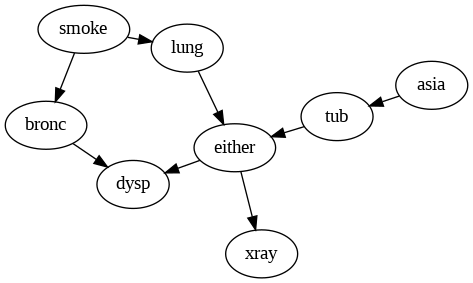

In [6]:
from IPython.display import Image
from pgmpy.utils import get_example_model
from pgmpy.inference import VariableElimination

asia_model = get_example_model("asia")
asia_infer = VariableElimination(asia_model)

# Visualize the network
viz = asia_model.to_graphviz()
viz.draw('asia.png', prog='neato')
Image('asia.png')

# Step 2: Inference Using Hard Evidence

In [4]:
# Computing the probability of bronc given smoke=no.
q = asia_infer.query(variables=["bronc"], evidence={"smoke": "no"})
print(q)

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(yes) |       0.3000 |
+------------+--------------+
| bronc(no)  |       0.7000 |
+------------+--------------+


In [7]:
# Computing the joint probability of bronc and asia given smoke=yes
q = asia_infer.query(variables=["bronc", "asia"], evidence={"smoke": "yes"})
print(q)

+------------+-----------+-------------------+
| bronc      | asia      |   phi(bronc,asia) |
+============+===========+===================+
| bronc(yes) | asia(yes) |            0.0060 |
+------------+-----------+-------------------+
| bronc(yes) | asia(no)  |            0.5940 |
+------------+-----------+-------------------+
| bronc(no)  | asia(yes) |            0.0040 |
+------------+-----------+-------------------+
| bronc(no)  | asia(no)  |            0.3960 |
+------------+-----------+-------------------+


In [8]:
# Computing the probabilities (not joint) of bronc and asia given smoke=no
q = asia_infer.query(variables=["bronc", "asia"], evidence={"smoke": "no"}, joint=False)
for factor in q.values():
    print(factor)

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(yes) |       0.3000 |
+------------+--------------+
| bronc(no)  |       0.7000 |
+------------+--------------+
+-----------+-------------+
| asia      |   phi(asia) |
+===========+=============+
| asia(yes) |      0.0100 |
+-----------+-------------+
| asia(no)  |      0.9900 |
+-----------+-------------+


# Step 3: Calculating MAP Using Hard Evidence

A maximum a posteriori probability (MAP) estimate is an estimate of an unknown quantity, that equals the mode of the posterior distribution. The MAP can be used to obtain a point estimate of an unobserved quantity on the basis of empirical data.

In [9]:
# Computing the MAP of bronc given smoke=no.
q = asia_infer.map_query(variables=["bronc"], evidence={"smoke": "no"})
print(q)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'bronc': 'no'}


In [10]:
# Computing the MAP of bronc and asia given smoke=yes
q = asia_infer.map_query(variables=["bronc", "asia"], evidence={"smoke": "yes"})
print(q)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'bronc': 'yes', 'asia': 'no'}


# Step 4: Inference using virtual evidence

Hard evidence refers to a definite observation of a variable's value, while virtual evidence (also known as soft evidence) introduces uncertainty or ambiguity about a variable's value.

In [22]:
from pgmpy.factors.discrete import TabularCPD

# Query with hard evidence "smoke=no" and "virtual_evidences_lung"
lung_virt_evidence = TabularCPD(
    variable="lung",
    variable_card=2,
    values=[[0.4], [0.6]],
    state_names = asia_model.get_cpds('lung').state_names
)

q = asia_infer.query(
    variables=["bronc"], evidence={"smoke": "no"}, virtual_evidence=[lung_virt_evidence]
)
print(q)

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(yes) |       0.3000 |
+------------+--------------+
| bronc(no)  |       0.7000 |
+------------+--------------+


# Troubleshooting for slow inference

In the case of large models, or models in which variables have a lot of states, inference can be quite slow. Some of the ways to deal with it are:

1. Reduce the number of states of variables by combining states together.

2. Try a different elimination order by specifying `elimination_order` argument. Possible options are: `MinFill`, `MinNeighbors`, `MinWeight`, `WeightedMinFill`.

3. Try a custom elimination order: The implemented heuristics for computing the elimination order might not be efficient in every case. If you can think of a more efficient order, you can also pass it as a list to the `elimination_order` argument.

4. If it is still too slow, try using approximate inference using sampling algorithms.


The original source can be seen [here](https://pgmpy.org/examples/Inference_Discrete_BN.html)